<h1>GRU</h1>

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

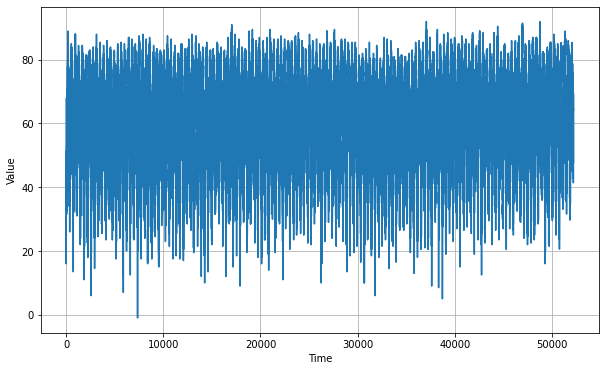

In [4]:
import csv
time_step = []
temps = []

with open('Birmingham-mean.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [5]:
split_time = 40000
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:]

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.GRU(100, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.GRU(100), 
  tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mae"])
history = model.fit(train_set, epochs=100, verbose=1)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(40000,)
Epoch 1/100
156/156 [==============================] - 24s 135ms/step - loss: 2064.0029 - mae: 42.4920
Epoch 2/100
156/156 [==============================] - 22s 143ms/step - loss: 1027.4462 - mae: 28.5272
Epoch 3/100
156/156 [==============================] - 24s 154ms/step - loss: 542.3972 - mae: 19.8516
Epoch 4/100
156/156 [==============================] - 24s 152ms/step - loss: 331.8900 - mae: 15.5550
Epoch 5/100
156/156 [==============================] - 24s 152ms/step - loss: 256.0561 - mae: 13.8098
Epoch 6/100
156/156 [==============================] - 23s 150ms/step - loss: 214.4535 - mae: 12.5963
Epoch 7/100
156/156 [==============================] - 24s 152ms/step - loss: 129.8772 - mae: 9.6834
Epoch 8/100
156/156 [==============================] - 24s 153ms/step - loss: 99.0390 - mae: 8.4004
Epoch 9/100
156/156 [==============================] - 23s 146ms/step - loss: 83.6

156/156 [==============================] - 23s 146ms/step - loss: 65.8337 - mae: 6.2599
Epoch 82/100
156/156 [==============================] - 23s 146ms/step - loss: 65.8382 - mae: 6.2603
Epoch 83/100
156/156 [==============================] - 23s 146ms/step - loss: 65.8363 - mae: 6.2601
Epoch 84/100
156/156 [==============================] - 24s 151ms/step - loss: 65.8307 - mae: 6.2598
Epoch 85/100
156/156 [==============================] - 24s 155ms/step - loss: 65.8360 - mae: 6.2602
Epoch 86/100
156/156 [==============================] - 23s 148ms/step - loss: 65.8321 - mae: 6.2599
Epoch 87/100
156/156 [==============================] - 23s 147ms/step - loss: 65.8345 - mae: 6.2600
Epoch 88/100
156/156 [==============================] - 23s 148ms/step - loss: 65.8378 - mae: 6.2602
Epoch 89/100
156/156 [==============================] - 24s 151ms/step - loss: 65.8302 - mae: 6.2597
Epoch 90/100
156/156 [==============================] - 24s 150ms/step - loss: 65.8337 - mae: 6.2599
Epo

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 100)         30900     
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               60600     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 91,601
Trainable params: 91,601
Non-trainable params: 0
_________________________________________________________________


In [10]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1) 
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
forecast = model_forecast(model, series[split_time - window_size: -1], window_size)[:,0]

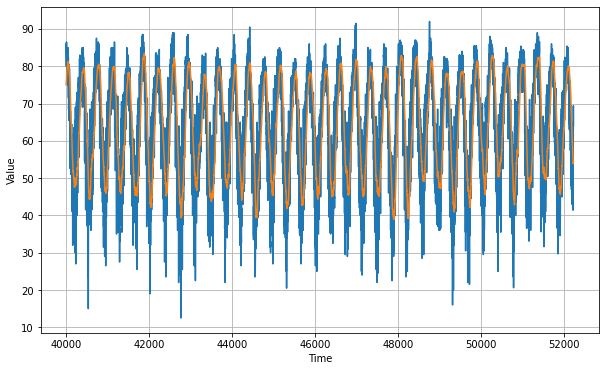

In [15]:
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, forecast).numpy()

7.7253323

In [17]:
model.save('GRU_model.h5')

In [18]:
model = tf.keras.models.load_model('GRU_model.h5')